In [1]:
import tensorflow as tf
import torch
from patchify import patchify, unpatchify
from skimage import io, measure
import matplotlib.pyplot as plt
import keras
from keras import layers
import numpy as np

from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    ScaleIntensityRanged,
    ScaleIntensityd,
    CropForegroundd,
    Resized,
    ToTensord,
    RandFlipd, RandRotate90d, MapTransform
    
)

from monai.data import DataLoader, Dataset
from monai.utils import first
#import segmentation_models_3D as sm

import glob
from sklearn.model_selection import train_test_split

In [2]:
liver_file = "images/liver_0.nii"
liver_lab = "mask/lab_liver_0.nii"

images = io.imread(liver_file)
masks = io.imread(liver_lab)

In [3]:
np.min(images), np.max(images), np.min(masks), np.max(masks)

(-1024.0, 1343.0474, 0.0, 2.0)

In [4]:
# class ToTFTransform(MapTransform):
#     """
#     Custom transform to convert data to TensorFlow tensors.
#     """
#     def __init__(self, keys):
#         super().__init__(keys)

#     def __call__(self, data):
#         for key in self.keys:
#             data[key] = tf.convert_to_tensor(data[key])
#         return data

In [5]:
tr_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.0)),
    ScaleIntensityRanged(keys=['image'], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
    ScaleIntensityd(keys='label'),
    CropForegroundd(keys=['image', 'label'], source_key='image', allow_smaller=False),
    Resized(keys=['image', 'label'], spatial_size=[128, 128, 128]),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=[0, 1]),
    RandRotate90d(keys=['image', 'label'], prob=0.5),
    ToTensord(keys=["image", "label"])  # Convert to TensorFlow tensors
])

In [6]:
out = tr_transforms({'image':liver_file, 'label':liver_lab})

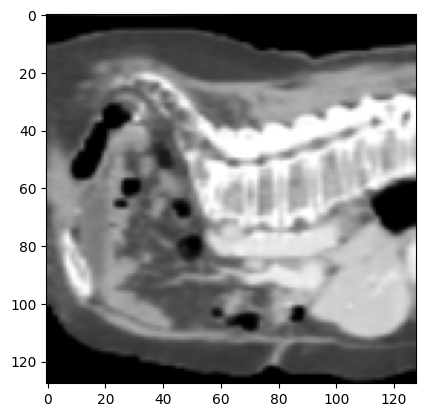

In [7]:
plt.imshow(out['image'][0, :, 60, :], cmap='gray')

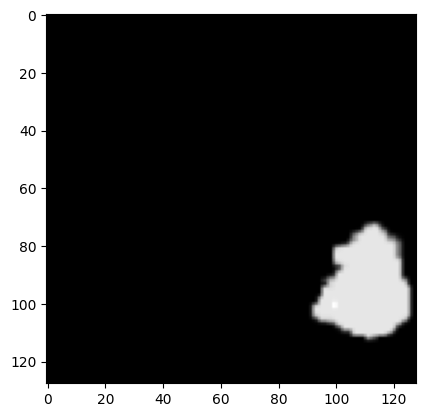

In [8]:
plt.imshow(out['label'][0, :, 60, :], cmap='gray')

In [9]:
image_files = glob.glob('images/*.nii')
label_files = glob.glob('mask/*.nii')

train_files = [{'image': image_file, 'label':label_file} for image_file, label_file in zip(image_files, label_files)]

In [10]:
train_ds = Dataset(data=train_files, transform=tr_transforms)
train_ds = DataLoader(train_ds, batch_size=2)

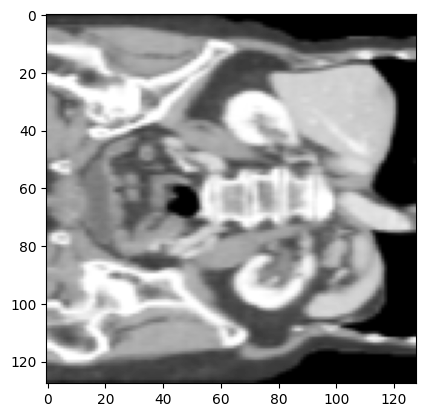

In [12]:
sample = first(train_ds)

plt.imshow(sample['image'][0, 0, :, 60, :], cmap='gray')

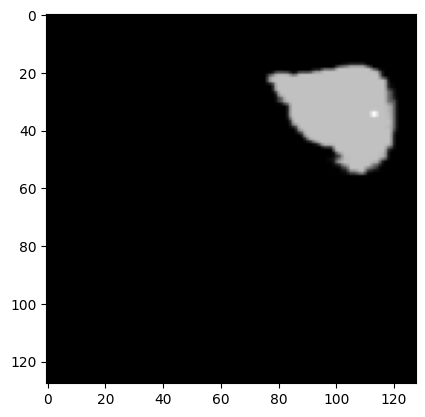

In [13]:
plt.imshow(sample['label'][0, 0, :, 60, :], cmap='gray')

In [121]:
train_ds = tf.data.Dataset.from_tensor_slices((image_files, label_files))

In [122]:
for im in train_ds:
    print(im)

(<tf.Tensor: shape=(), dtype=string, numpy=b'images\\liver_0.nii'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask\\lab_liver_0.nii'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'images\\liver_1.nii'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask\\lab_liver_1.nii'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'images\\liver_10.nii'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask\\lab_liver_10.nii'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'images\\liver_101.nii'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask\\lab_liver_101.nii'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'images\\liver_102.nii'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask\\lab_liver_102.nii'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'images\\liver_108.nii'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask\\lab_liver_108.nii'>)


In [123]:
def load_and_preprocess_vol(im_file, lab_file):
    vol_dict_transformed = tr_transforms({'image':str(im_file), 'label':str(lab_file)})
    return vol_dict_transformed['image'], vol_dict_transformed['label']

In [124]:
ds = train_ds.map(lambda im, lab: tf.py_function(func=load_and_preprocess_vol, inp=[im, lab], Tout=[tf.float32, tf.float32]))

In [125]:
for im, lab in ds:
    print(im.shape, lab.shape)

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:13 transformation with iterator: Iterator::Root::Prefetch::Map: RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000020D2E02AA70>
Traceback (most recent call last):

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\nibabel\loadsave.py", line 101, in load
    stat_result = os.stat(filename)

FileNotFoundError: [WinError 3] The system cannot find the path specified: "tf.Tensor(b'images/liver_0.nii', shape=(), dtype=string)"


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\monai\transforms\transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\monai\transforms\transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\monai\transforms\io\dictionary.py", line 163, in __call__
    data = self._loader(d[key], reader)

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\monai\transforms\io\array.py", line 264, in __call__
    img = reader.read(filename)

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\monai\data\image_reader.py", line 922, in read
    img = nib.load(name, **kwargs_)

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\nibabel\loadsave.py", line 103, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")

FileNotFoundError: No such file or no access: 'tf.Tensor(b'images/liver_0.nii', shape=(), dtype=string)'


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21188\1737834967.py", line 2, in load_and_preprocess_vol
    vol_dict_transformed = tr_transforms({'image':str(im_file), 'label':str(lab_file)})

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\monai\transforms\compose.py", line 335, in __call__
    result = execute_compose(

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\monai\transforms\compose.py", line 111, in execute_compose
    data = apply_transform(

  File "C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\monai\transforms\transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e

RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000020D2E02AA70>


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [5]:
img_patches = patchify(images, (64, 64, 64), step=64)
mask_patches = patchify(masks, (64, 64, 64), step=64)

In [6]:
img_patches.shape

(2, 2, 2, 64, 64, 64)

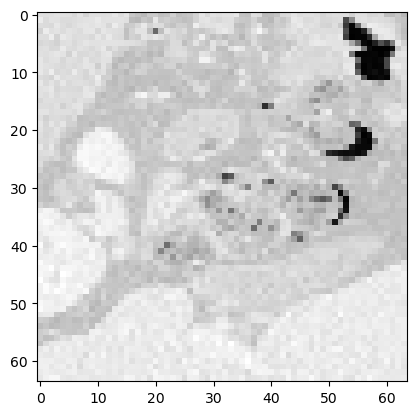

In [7]:
plt.imshow(img_patches[1, 1, 1, :, :, 50], cmap='gray')

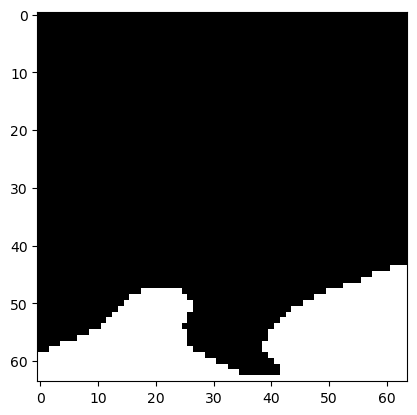

In [8]:
plt.imshow(mask_patches[1, 1, 1, :, :, 50], cmap='gray')

In [9]:
inp_image = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
inp_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

In [10]:
def normalize_vol(image_data):
    # Normalize to [0, 255]
    min_val = np.min(image_data)
    max_val = np.max(image_data)

    scaled_data = 255 * (image_data - min_val) / (max_val - min_val)

    # Convert to unsigned 8-bit integer
    #scaled_data = scaled_data.astype(np.uint8)
    return scaled_data

In [11]:
def extract_comb_patches(path):
    arr_list = []
    for image_path in path:
        image_vol = io.imread(image_path)
        norm_imagevol = normalize_vol(image_vol)
        try:
            img_patches = patchify(norm_imagevol, (64, 64, 64), step=64)
            inp_images = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
            arr_list.append(inp_images)
        except Exception as e:
            pass
        

    arr_list = np.concatenate(arr_list, axis=0)
    return arr_list

In [12]:
inp_image_train = extract_comb_patches(glob.glob('images/*.nii'))
inp_mask_train = extract_comb_patches(glob.glob('mask/*.nii'))

In [13]:
inp_image_train.shape, inp_mask_train.shape

((62, 64, 64, 64), (62, 64, 64, 64))

In [14]:
train_img = np.expand_dims(inp_image_train, axis=-1)
train_mask = np.expand_dims(inp_mask_train, axis=-1)

#train_mask_cat = keras.utils.to_categorical(train_mask, num_classes=1)

train_img.shape

(62, 64, 64, 64, 1)

In [15]:
train_mask.shape

(62, 64, 64, 64, 1)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(train_img, train_mask, test_size=0.10)

In [17]:
x_train = x_train / 255
x_test = x_test / 255

In [18]:
y_train = y_train / 255.0
y_test = y_test / 255.0

In [19]:
print(np.max(x_train), np.max(y_train))

1.0 1.0


## plain 3d unet

In [37]:
from volumentations import *

def get_augmentation():
    return Compose([Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
                    Flip(0, p=0.5),
                    Flip(1, p=0.5),
                    Flip(2, p=0.5),
                    ElasticTransform((0, 0.25), interpolation=2, p=0.1),
                    RandomRotate90((1, 2), p=0.5),
                    GaussianNoise(var_limit=(0, 5), p=0.2),
                    RandomGamma(gamma_limit=(0.5, 1.5), p=0.2)], p=1.0)

In [38]:
augmentor = get_augmentation()

In [39]:


augmented = augmentor(np.ones(shape=(64, 64, 64)))
augmented.shape

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [17]:
# variable utils
#image_size = (64, 64, 64)
image_shape = (64, 64, 64, 1)
batch_size = 8

filters = [64, 128, 256, 512, 512, 512]
bn = [False, True, True, True, True, True]
dropout = [True, True, True, False, False]

kernel_size = 3

In [18]:
def downsample(filters, k_size, bn=True):
    model = keras.Sequential()
    model.add(layers.Conv3D(filters, k_size, padding="same", use_bias=False))
    if bn:
        model.add(layers.BatchNormalization())
        
    model.add(layers.ReLU()) 
    model.add(layers.MaxPooling3D((2, 2, 2)))
    
    def apply(x):
        x = model(x)
        return x

    return apply

In [19]:
test = tf.random.normal([1, 64, 64, 64, 1])
x = downsample(64, 3)(test)
x.shape

TensorShape([1, 32, 32, 32, 64])

In [20]:
def upsample(filters, k_size, dropout=False):
    model = keras.Sequential()
    model.add(layers.Conv3DTranspose(filters, k_size, strides=(2, 2, 2), padding="same"))
    if dropout:
        model.add(layers.Dropout(0.25))

    model.add(layers.ReLU())

    def apply(x):
        x = model(x)
        return x

    return apply

In [21]:
out = upsample(1, 3)(x)
out.shape

TensorShape([1, 64, 64, 64, 1])

In [22]:
def Unet3d():
    inputs = layers.Input(shape=image_shape)
    x = inputs
    skip = []
    
    for f, b in zip(filters, bn):
        x = downsample(f, kernel_size, b)(x)
        skip.append(x)

    for f, a, sk in zip(reversed(filters[:-1]), dropout, reversed(skip[:-1])):
        x = upsample(f, kernel_size, a)(x)
        x = layers.Concatenate()([x, sk])

    final_layer = layers.Conv3DTranspose(1, kernel_size, strides=(2, 2, 2), activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, final_layer)
    return model

In [50]:
unet3d_model = Unet3d()
unet3d_model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)   │ (None, 64, 64, 64, 1)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_24 (Sequential)    │ (None, 32, 32, 32, 64)    │           1,728 │ input_layer_26[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_25 (Sequential)    │ (None, 16, 16, 16, 128)   │         221,696 │ sequential_24[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_26 (Sequential)    │ (None, 8, 8, 8, 256)      │         885,760 │ sequential_25[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_27 (Sequential)    │ (None, 4, 4, 4, 512)      │       3,540,992 │ sequential_26[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_28 (Sequential)    │ (None, 2, 2, 2, 512)      │       7,079,936 │ sequential_27[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_29 (Sequential)    │ (None, 1, 1, 1, 512)      │       7,079,936 │ sequential_28[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_30 (Sequential)    │ (None, 2, 2, 2, 512)      │       7,078,400 │ sequential_29[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_10 (Concatenate)  │ (None, 2, 2, 2, 1024)     │               0 │ sequential_30[0][0],       │
│                               │                           │                 │ sequential_28[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_31 (Sequential)    │ (None, 4, 4, 4, 512)      │      14,156,288 │ concatenate_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_11 (Concatenate)  │ (None, 4, 4, 4, 1024)     │               0 │ sequential_31[0][0],       │
│                               │                           │                 │ sequential_27[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_32 (Sequential)    │ (None, 8, 8, 8, 256)      │       7,078,144 │ concatenate_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_12 (Concatenate)  │ (None, 8, 8, 8, 512)      │               0 │ sequential_32[0][0],       │
│                               │                           │                 │ sequential_26[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_33 (Sequential)    │ (None, 16, 16, 16, 128)   │       1,769,600 │ concatenate_12[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_13 (Concatenate)  │ (None, 16, 16, 16, 256)   │               0 │ sequential_33[0][0],       │
│                               │                           │                 │ sequential_25[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 49,338,369 (188.21 MB)

 Trainable params: 49,334,529 (188.20 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [24]:
# def dice_coefficient(y_true, y_pred):
#     smoothing_factor = 1e-6
#     flat_y_true = tf.reshape(y_true, [-1])
#     flat_y_pred = tf.reshape(y_pred, [-1])
#     return (2*tf.reduce_sum(flat_y_true*flat_y_pred)+smoothing_factor)/(tf.reduce_sum(flat_y_true)+tf.reduce_sum(flat_y_pred)+smoothing_factor)


# def dice_coefficient_loss(y_true, y_pred):
#     return 1-dice_coefficient(y_true, y_pred)


# def iou_score(y_true, y_pred):
#     smooth = 1e-6
#     y_true = tf.where(y_true > 0.5, 1, 0)
#     y_pred = tf.where(y_pred > 0.5, 1, 0)
#     intersection = np.sum(np.logical_and(y_true, y_pred))
#     union = np.sum(np.logical_or(y_true, y_pred))
#     return (intersection + smooth) / (union + smooth)


In [25]:
# y_true_test = tf.random.normal([1, 64, 64, 64, 1])
# y_pred_test = tf.random.normal([1, 64, 64, 64, 1])

# dice_coefficient(y_pred_test, y_true_test)

In [26]:
# dice_coefficient_loss(y_pred_test, y_true_test)

In [27]:
# keras.losses.Dice()(y_true_test, y_pred_test)

In [28]:
# print("IoU Score:", iou_score(y_true_test, y_pred_test))

In [29]:
# new_y_true = tf.where(y_true_test > 0.5, 1, 0)
# new_y_pred = tf.where(y_pred_test > 0.5, 1, 0)

In [30]:
# print("IoU Score:", keras.metrics.IoU(num_classes=2, target_class_ids=[1])(new_y_true, new_y_pred))

In [51]:
unet3d_model.compile(loss=keras.losses.Dice(),
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    metrics = [keras.metrics.IoU(num_classes=2, target_class_ids=[1])])

In [52]:
history = unet3d_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test),
                          batch_size=8
                          )

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - io_u_4: 0.0000e+00 - loss: 0.9878

KeyboardInterrupt: 

In [16]:
# weights = 'imagenet'
# backbone = "vgg16"
# activation = 'sigmoid'
# patches = 64
# n_classes = 1
# channels = 3

# lr = 0.0001
# optim = keras.optimizers.Adam(lr)

# diceloss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = diceloss + (1 * focal_loss)

# metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [17]:
# model = keras.Sequential([
#               layers.Input(shape=(64, 64, 64, 3)),
#               layers.Lambda(keras.applications.vgg16.preprocess_input),
#               sm.Unet(backbone_name=backbone, classes=n_classes, activation=activation, encoder_weights=weights, input_shape=(patches, patches, patches, channels))])
# model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [18]:
# model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 64, 64, 64, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 64, 64, 64, 1)       │      71,232,241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,232,241 (271.73 MB)

 Trainable params: 71,228,209 (271.71 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [19]:
# history = model.fit(x_train, y_train,
#                     batch_size=8, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 187s 21s/step - f1-score: 0.0209 - iou_score: 0.0106 - loss: 0.9817 - val_f1-score: 0.0233 - val_iou_score: 0.0118 - val_loss: 0.9864
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 139s 20s/step - f1-score: 0.0333 - iou_score: 0.0172 - loss: 0.9710 - val_f1-score: 0.0123 - val_iou_score: 0.0062 - val_loss: 0.9858
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 144s 20s/step - f1-score: 0.0255 - iou_score: 0.0131 - loss: 0.9769 - val_f1-score: 0.0131 - val_iou_score: 0.0066 - val_loss: 0.9910
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 141s 20s/step - f1-score: 0.0354 - iou_score: 0.0182 - loss: 0.9688 - val_f1-score: 0.0052 - val_iou_score: 0.0026 - val_loss: 0.9941
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 20s/step - f1-score: 0.0357 - iou_score: 0.0185 - loss: 0.9699 - val_f1-score: 0.0029 - val_iou_score: 0.0014 - val_loss: 0.9943
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 141s 20s/step - f1-score: 0.0601 - iou_score: 0.0316 - loss: 0.9480 - val_f1-score: 1.8783e-04 - val_iou_score: 9.

KeyboardInterrupt: 